# Model Training Notebook - Simple and Clear
This notebook trains a neural network to predict structural responses.
Each step is explained simply with comments.

## Step 1: Import Libraries
We need to import all the tools we'll use.

In [1]:
# Import basic libraries
import pandas as pd  # For working with data tables
import numpy as np   # For math operations

# Import PyTorch for building neural networks
import torch
import torch.nn as nn  # Neural network components

# Import tools for preparing data
from sklearn.model_selection import train_test_split  # Split data into train/test
from sklearn.preprocessing import StandardScaler      # Normalize data

# Import tools for visualization
import matplotlib.pyplot as plt

# Print versions to make sure everything is installed
print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✅ All libraries imported successfully!
PyTorch version: 2.9.1+cpu
Using device: CPU


## Step 2: Load the Dataset
Load the data we generated in Phase 1.

In [2]:
# Load the CSV file into a pandas DataFrame
data = pd.read_csv("../data/fem_simulations.csv")

# Show basic information about the dataset
print(f"Total samples: {len(data)}")
print(f"Total columns: {len(data.columns)}")
print(f"\nColumn names:")
print(data.columns.tolist())

# Show first 5 rows to see what the data looks like
print("\nFirst 5 rows of data:")
data.head()

Total samples: 10000
Total columns: 19

Column names:
['sampleId', 'buildingType', 'numFloors', 'floorHeight', 'numBeams', 'numColumns', 'beamSection', 'columnSection', 'concreteStrength', 'steelGrade', 'steelGradeName', 'seismicZone', 'windLoad', 'liveLoad', 'deadLoad', 'maxDeflection', 'maxStress', 'stabilityIndex', 'seismicResistance']

First 5 rows of data:


,sampleId,buildingType,numFloors,floorHeight,numBeams,numColumns,beamSection,columnSection,concreteStrength,steelGrade,steelGradeName,seismicZone,windLoad,liveLoad,deadLoad,maxDeflection,maxStress,stabilityIndex,seismicResistance
0,1,residential,12,3.3,144,64,45,60,80,355,S355,Zone 0,0.69,1.64,4.30,4470.31,11.03,100.00,100.00
1,2,industrial,1,4.5,24,9,16,36,45,460,S460,Zone 1,0.59,5.70,7.17,110.64,504.55,97.56,89.25
2,3,commercial,1,4.5,24,9,14,22,30,460,S460,Zone 1,0.40,4.56,5.77,141.81,577.04,55.80,85.85
3,4,residential,6,2.7,84,36,26,26,35,275,S275,Zone 2,0.48,2.05,3.37,2823.53,52.71,100.00,76.58
4,5,industrial,3,5.0,40,16,24,45,50,420,S420,Zone 0,0.73,6.36,9.31,445.29,175.59,70.86,98.67


## Step 3: Prepare Input and Output Data
Separate the data into:
- **Inputs (X)**: The parameters we give to the model (11 parameters)
- **Outputs (Y)**: What we want the model to predict (4 values)

In [3]:
# Define which columns are inputs (the 11 parameters)
input_columns = [
    'numFloors',         # Number of floors in building
    'floorHeight',       # Height of each floor
    'numBeams',          # Number of beams
    'numColumns',        # Number of columns
    'beamSection',       # Size of beam cross-section
    'columnSection',     # Size of column cross-section
    'concreteStrength',  # Strength of concrete
    'steelGrade',        # Strength of steel
    'windLoad',          # Wind pressure
    'liveLoad',          # Live load (people, furniture)
    'deadLoad'           # Dead load (structure weight)
]

# Define which columns are outputs (what we want to predict)
output_columns = [
    'maxDeflection',      # How much the structure bends
    'maxStress',          # Maximum stress in materials
    'stabilityIndex',     # How stable the structure is (0-100)
    'seismicResistance'   # How well it resists earthquakes (0-100)
]

# Extract input data (X)
X = data[input_columns].values  # Convert to numpy array
print(f"Input shape: {X.shape}")  # Should be (10000, 11)

# Extract output data (Y)
Y = data[output_columns].values  # Convert to numpy array
print(f"Output shape: {Y.shape}")  # Should be (10000, 4)

# Show a sample
print("\nSample input (first row):")
print(X[0])
print("\nSample output (first row):")
print(Y[0])

Input shape: (10000, 11)
Output shape: (10000, 4)

Sample input (first row):
[ 12.     3.3  144.    64.    45.    60.    80.   355.     0.69   1.64
   4.3 ]

Sample output (first row):
[4470.31   11.03  100.    100.  ]


## Step 4: Split Data into Training and Testing Sets
We split data into two parts:
- **Training set (80%)**: Used to train the model
- **Testing set (20%)**: Used to test how well the model works

In [4]:
# Split data: 80% for training, 20% for testing
# random_state=42 makes sure we get the same split every time
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2,      # 20% for testing
    random_state=42     # Fixed random seed
)

print(f"Training samples: {len(X_train)}")  # Should be 8000
print(f"Testing samples: {len(X_test)}")    # Should be 2000

Training samples: 8000
Testing samples: 2000


## Step 5: Normalize the Data
Normalization makes all numbers similar in size (mean=0, std=1).
This helps the neural network learn better and faster.

In [5]:
# Create a scaler object
scaler_X = StandardScaler()  # For inputs
scaler_Y = StandardScaler()  # For outputs

# Fit the scaler on training data and transform it
X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

# Transform test data using the same scaler (important!)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

print("✅ Data normalized successfully!")
print(f"\nBefore normalization - X mean: {X_train.mean():.2f}")
print(f"After normalization - X mean: {X_train_scaled.mean():.2f}")

✅ Data normalized successfully!

Before normalization - X mean: 53.63
After normalization - X mean: 0.00


## Step 6: Convert to PyTorch Tensors
PyTorch uses "tensors" instead of numpy arrays.
We need to convert our data to tensors.

In [6]:
# Convert numpy arrays to PyTorch tensors
# dtype=torch.float32 means we use 32-bit floating point numbers
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32)

print("✅ Data converted to PyTorch tensors!")
print(f"X_train shape: {X_train_tensor.shape}")
print(f"Y_train shape: {Y_train_tensor.shape}")

✅ Data converted to PyTorch tensors!
X_train shape: torch.Size([8000, 11])
Y_train shape: torch.Size([8000, 4])


## Step 7: Define the Neural Network Model
We create a simple neural network with:
- **Input layer**: 11 neurons (11 input parameters)
- **Hidden layer 1**: 64 neurons
- **Hidden layer 2**: 32 neurons
- **Output layer**: 4 neurons (4 predictions)

In [7]:
# Define our neural network class
class SimpleNeuralNetwork(nn.Module):
    """
    A simple neural network for structural analysis prediction.
    """
    
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Layer 1: Input (11) -> Hidden (64)
        self.layer1 = nn.Linear(11, 64)
        
        # Layer 2: Hidden (64) -> Hidden (32)
        self.layer2 = nn.Linear(64, 32)
        
        # Layer 3: Hidden (32) -> Output (4)
        self.layer3 = nn.Linear(32, 4)
        
        # Activation function (ReLU = Rectified Linear Unit)
        # ReLU(x) = max(0, x) - simple and works well
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        This function defines how data flows through the network.
        Input -> Layer1 -> ReLU -> Layer2 -> ReLU -> Layer3 -> Output
        """
        # Pass through layer 1 and apply ReLU
        x = self.relu(self.layer1(x))
        
        # Pass through layer 2 and apply ReLU
        x = self.relu(self.layer2(x))
        
        # Pass through layer 3 (no ReLU at output)
        x = self.layer3(x)
        
        return x

# Create the model
model = SimpleNeuralNetwork()

print("✅ Neural network created!")
print("\nModel architecture:")
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

✅ Neural network created!

Model architecture:
SimpleNeuralNetwork(
  (layer1): Linear(in_features=11, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)

Total parameters: 2,980


## Step 8: Define Loss Function and Optimizer
- **Loss function**: Measures how wrong the predictions are (we use MSE - Mean Squared Error)
- **Optimizer**: Adjusts the model to reduce the loss (we use Adam - a popular optimizer)

In [8]:
# Loss function: Mean Squared Error
# It calculates: average of (predicted - actual)²
loss_function = nn.MSELoss()

# Optimizer: Adam (Adaptive Moment Estimation)
# lr = learning rate (how big steps to take when learning)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✅ Loss function and optimizer ready!")
print(f"Loss function: {loss_function}")
print(f"Optimizer: {optimizer}")

✅ Loss function and optimizer ready!
Loss function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Step 9: Train the Model
Training means showing the model examples and letting it learn.
We do this in "epochs" - each epoch is one pass through all training data.

In [9]:
# Training settings
num_epochs = 100  # How many times to go through all data
batch_size = 32   # How many samples to process at once

# Lists to store loss values for plotting later
train_losses = []

print("🚀 Starting training...")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print("-" * 50)

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # Variables to track loss
    epoch_loss = 0
    num_batches = 0
    
    # Process data in batches
    for i in range(0, len(X_train_tensor), batch_size):
        # Get a batch of data
        batch_X = X_train_tensor[i:i+batch_size]
        batch_Y = Y_train_tensor[i:i+batch_size]
        
        # Step 1: Reset gradients to zero
        optimizer.zero_grad()
        
        # Step 2: Forward pass - make predictions
        predictions = model(batch_X)
        
        # Step 3: Calculate loss (how wrong are we?)
        loss = loss_function(predictions, batch_Y)
        
        # Step 4: Backward pass - calculate gradients
        loss.backward()
        
        # Step 5: Update weights using optimizer
        optimizer.step()
        
        # Track the loss
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for this epoch
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")

print("-" * 50)
print("✅ Training complete!")

🚀 Starting training...
Epochs: 100
Batch size: 32
--------------------------------------------------
Epoch [10/100] - Loss: 0.380026
Epoch [10/100] - Loss: 0.380026
Epoch [20/100] - Loss: 0.307282
Epoch [20/100] - Loss: 0.307282
Epoch [30/100] - Loss: 0.263443
Epoch [30/100] - Loss: 0.263443
Epoch [40/100] - Loss: 0.240039
Epoch [40/100] - Loss: 0.240039
Epoch [50/100] - Loss: 0.227242
Epoch [50/100] - Loss: 0.227242
Epoch [60/100] - Loss: 0.219380
Epoch [60/100] - Loss: 0.219380
Epoch [70/100] - Loss: 0.214199
Epoch [70/100] - Loss: 0.214199
Epoch [80/100] - Loss: 0.209846
Epoch [80/100] - Loss: 0.209846
Epoch [90/100] - Loss: 0.206675
Epoch [90/100] - Loss: 0.206675
Epoch [100/100] - Loss: 0.203945
--------------------------------------------------
✅ Training complete!
Epoch [100/100] - Loss: 0.203945
--------------------------------------------------
✅ Training complete!


## Step 10: Plot Training Progress
Let's see how the loss decreased during training.
A decreasing loss means the model is learning!

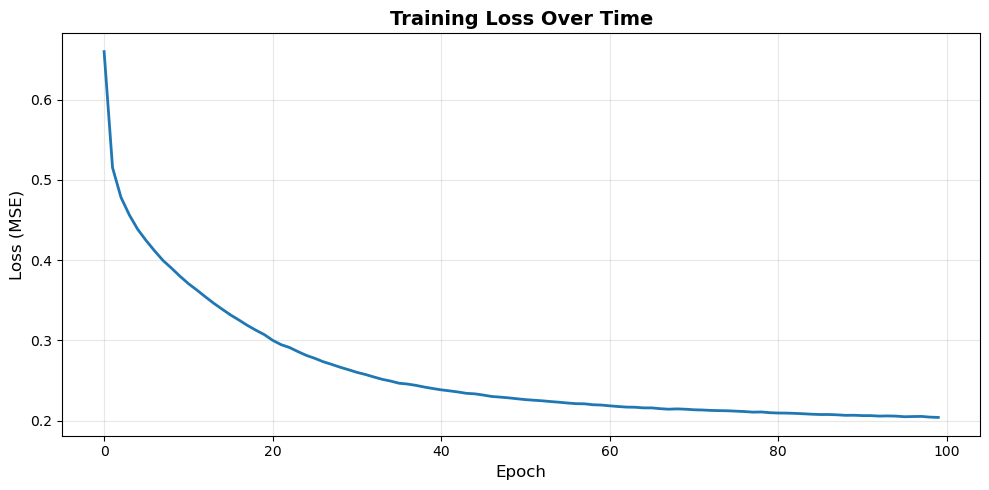


Initial loss: 0.660018
Final loss: 0.203945
Loss reduction: 69.10%


In [10]:
# Create a plot of the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInitial loss: {train_losses[0]:.6f}")
print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")

## Step 11: Test the Model
Now let's see how well the model performs on data it has never seen before!

In [11]:
# Set model to evaluation mode (turns off training features)
model.eval()

# Disable gradient calculation (we don't need it for testing)
with torch.no_grad():
    # Make predictions on test data
    test_predictions = model(X_test_tensor)

# Convert tensors back to numpy arrays
test_predictions_np = test_predictions.numpy()
Y_test_scaled_np = Y_test_scaled

# Calculate test loss
test_loss = np.mean((test_predictions_np - Y_test_scaled_np) ** 2)
print(f"Test Loss (MSE): {test_loss:.6f}")

# Transform predictions back to original scale
predictions_original = scaler_Y.inverse_transform(test_predictions_np)
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled_np)

print("\n✅ Model tested on unseen data!")

Test Loss (MSE): 0.278506

✅ Model tested on unseen data!


## Step 12: Evaluate Model Performance
Let's calculate how accurate the predictions are for each output.

In [12]:
# Calculate Mean Absolute Error (MAE) for each output
# MAE = average of |predicted - actual|
output_names = ['maxDeflection', 'maxStress', 'stabilityIndex', 'seismicResistance']

print("Model Performance (Mean Absolute Error):")
print("-" * 60)

for i, name in enumerate(output_names):
    # Get predictions and actual values for this output
    pred = predictions_original[:, i]
    actual = Y_test_original[:, i]
    
    # Calculate MAE
    mae = np.mean(np.abs(pred - actual))
    
    # Calculate percentage error
    mean_actual = np.mean(actual)
    percentage_error = (mae / mean_actual) * 100
    
    print(f"{name:20s}: MAE = {mae:10.2f}  ({percentage_error:.2f}% error)")

print("-" * 60)

Model Performance (Mean Absolute Error):
------------------------------------------------------------
maxDeflection       : MAE =   71158.32  (109.46% error)
maxStress           : MAE =      21.26  (9.09% error)
stabilityIndex      : MAE =       1.18  (1.33% error)
seismicResistance   : MAE =       9.87  (12.05% error)
------------------------------------------------------------


## Step 13: Visualize Predictions vs Actual
Let's create scatter plots to see how close our predictions are to reality.

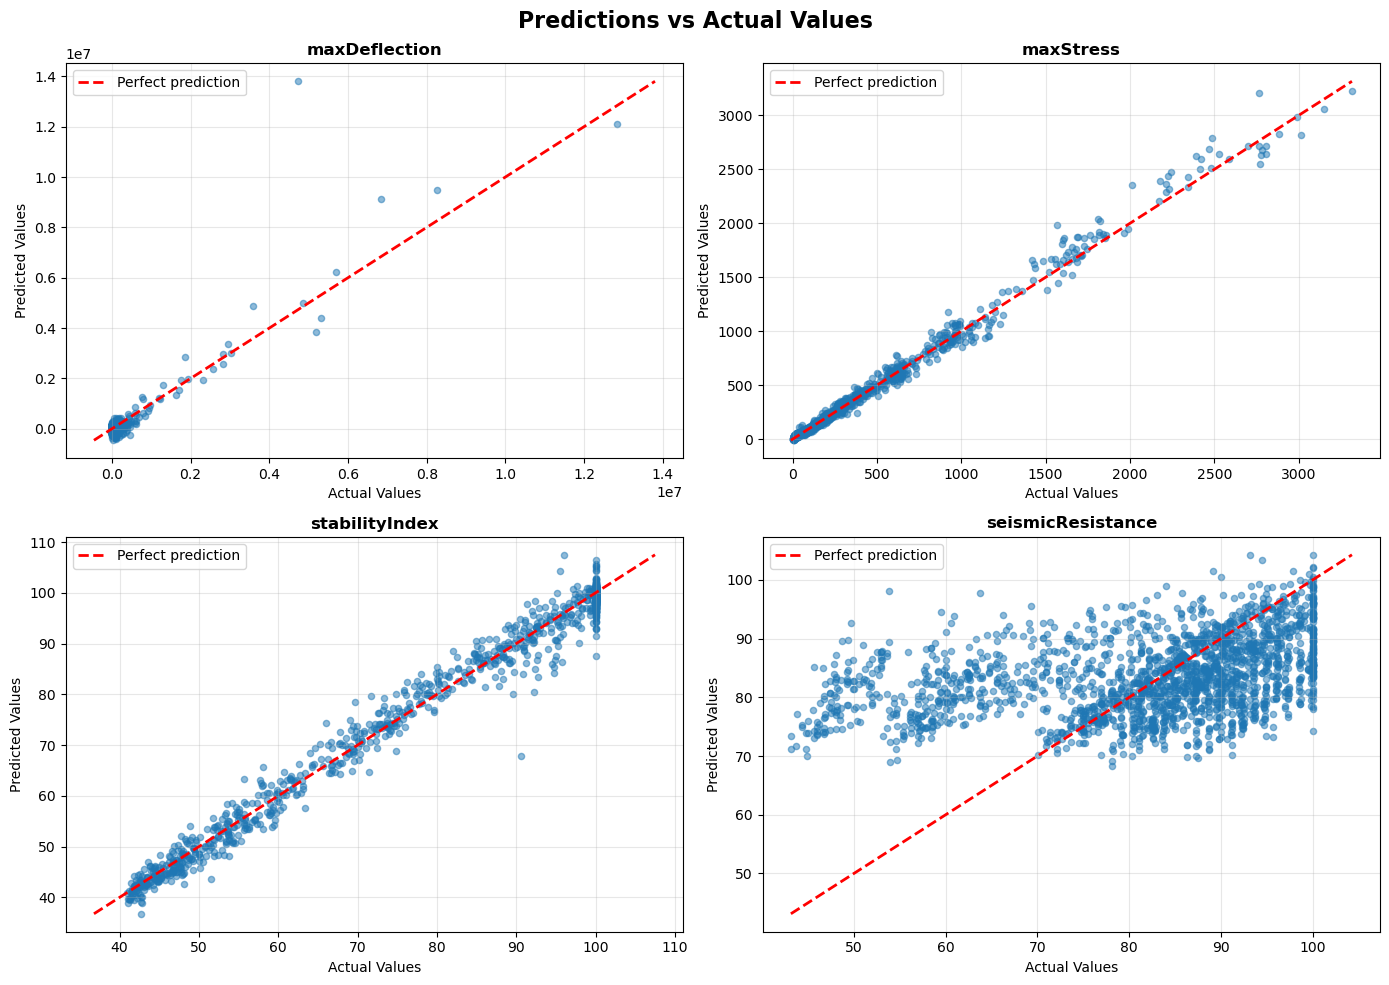

In [13]:
# Create 4 subplots (one for each output)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Predictions vs Actual Values', fontsize=16, fontweight='bold')

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each output
for i, name in enumerate(output_names):
    ax = axes[i]
    
    # Get data
    pred = predictions_original[:, i]
    actual = Y_test_original[:, i]
    
    # Create scatter plot
    ax.scatter(actual, pred, alpha=0.5, s=20)
    
    # Add perfect prediction line (y=x)
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    # Labels and title
    ax.set_xlabel('Actual Values', fontsize=10)
    ax.set_ylabel('Predicted Values', fontsize=10)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 14: Test with a Real Example
Let's test the model with a specific building configuration.

In [14]:
# Create a sample building configuration
sample_building = {
    'numFloors': 10,
    'floorHeight': 3.5,
    'numBeams': 120,
    'numColumns': 36,
    'beamSection': 30,
    'columnSection': 40,
    'concreteStrength': 35,
    'steelGrade': 355,
    'windLoad': 1.5,
    'liveLoad': 3.0,
    'deadLoad': 5.0
}

print("Testing with sample building:")
print("-" * 50)
for key, value in sample_building.items():
    print(f"{key:20s}: {value}")
print("-" * 50)

# Convert to the format our model expects
sample_input = np.array([[
    sample_building['numFloors'],
    sample_building['floorHeight'],
    sample_building['numBeams'],
    sample_building['numColumns'],
    sample_building['beamSection'],
    sample_building['columnSection'],
    sample_building['concreteStrength'],
    sample_building['steelGrade'],
    sample_building['windLoad'],
    sample_building['liveLoad'],
    sample_building['deadLoad']
]])

# Normalize the input
sample_scaled = scaler_X.transform(sample_input)

# Convert to tensor
sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

# Make prediction
model.eval()
with torch.no_grad():
    prediction_scaled = model(sample_tensor)

# Convert back to original scale
prediction = scaler_Y.inverse_transform(prediction_scaled.numpy())

# Display results
print("\n📊 Predictions:")
print("-" * 50)
for i, name in enumerate(output_names):
    value = prediction[0, i]
    print(f"{name:20s}: {value:.2f}")
print("-" * 50)

Testing with sample building:
--------------------------------------------------
numFloors           : 10
floorHeight         : 3.5
numBeams            : 120
numColumns          : 36
beamSection         : 30
columnSection       : 40
concreteStrength    : 35
steelGrade          : 355
windLoad            : 1.5
liveLoad            : 3.0
deadLoad            : 5.0
--------------------------------------------------

📊 Predictions:
--------------------------------------------------
maxDeflection       : -264865.81
maxStress           : 42.58
stabilityIndex      : 100.31
seismicResistance   : 82.54
--------------------------------------------------


## Step 15: Save the Model
Save the trained model so we can use it later in our API.

In [15]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save the PyTorch model
model_path = "../models/structural_model.pt"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# Save the scalers (we need these to normalize new data)
scaler_path = "../models/scalers.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump({
        'scaler_X': scaler_X,
        'scaler_Y': scaler_Y
    }, f)
print(f"✅ Scalers saved to: {scaler_path}")

# Save model info
info = {
    'input_features': input_columns,
    'output_features': output_names,
    'num_epochs': num_epochs,
    'final_train_loss': train_losses[-1],
    'test_loss': test_loss,
    'model_architecture': str(model)
}

info_path = "../models/model_info.pkl"
with open(info_path, 'wb') as f:
    pickle.dump(info, f)
print(f"✅ Model info saved to: {info_path}")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE!")
print("="*50)
print("Next step: Create API to use this model")

✅ Model saved to: ../models/structural_model.pt
✅ Scalers saved to: ../models/scalers.pkl
✅ Model info saved to: ../models/model_info.pkl

MODEL TRAINING COMPLETE!
Next step: Create API to use this model
